--------------------------------------------------------
        area     price            street     ward    district
16  4.400603  0.788457  Đoàn Nguyễn Tuấn  Quy Đức  Bình Chánh
14  4.454347  0.587787  Đoàn Nguyễn Tuấn  Quy Đức  Bình Chánh
22  4.461300  1.047319  Đoàn Nguyễn Tuấn  Quy Đức  Bình Chánh
6   4.465908  1.047319  Đoàn Nguyễn Tuấn  Quy Đức  Bình Chánh
8   4.510860  0.615186  Đoàn Nguyễn Tuấn  Quy Đức  Bình Chánh
--------------------------------------------------------
Log Transformation Data length:  14
Model coefficient:  [[0.31956498]]
Model intercept  [-0.45573251]


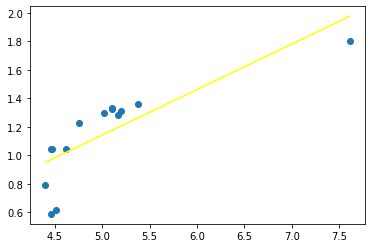

Root Mean Square Error:  0.18426643822509406


Use polynomial regression with degree = 2: 


Model coefficient:  [[ 0.          2.15111081 -0.15350858]]
Model intercept:  [-5.68518288]


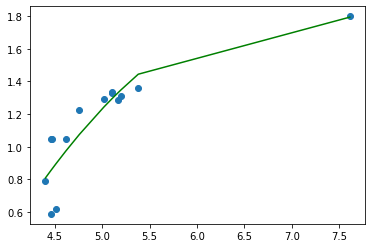

Root Mean Square Error:  0.13709870717330191


Use polynomial regression with degree = 3: 


Model coefficient:  [[ 0.         25.67499874 -4.35440016  0.24330286]]
Model intercept:  [-48.64275944]


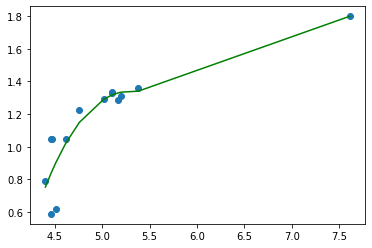

Root Mean Square Error:  0.13003361093105267


Use polynomial regression with degree = 4: 


Model coefficient:  [[  0.         -14.3432286    6.75629856  -1.1095746    0.06079059]]
Model intercept:  [4.79840109]


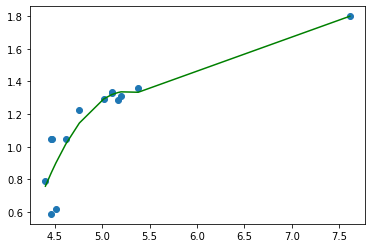

Root Mean Square Error:  0.12998949739580073


Use polynomial regression with degree = 5: 


Model coefficient:  [[ 0.00000000e+00 -1.16512060e+04  4.41747986e+03 -8.30104056e+02
   7.72306171e+01 -2.84196679e+00]]
Model intercept:  [12195.38823411]


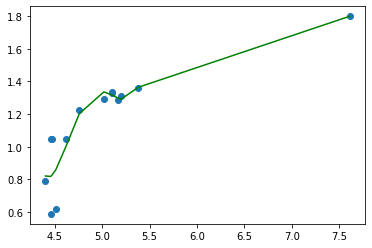

Root Mean Square Error:  0.12550922502163397


Use polynomial regression with degree = 6: 


Model coefficient:  [[ 0.00000000e+00 -4.80221404e+04  2.19784372e+04 -5.32650122e+03
   7.20724673e+02 -5.16076751e+01  1.52730477e+00]]
Model intercept:  [43420.68034501]


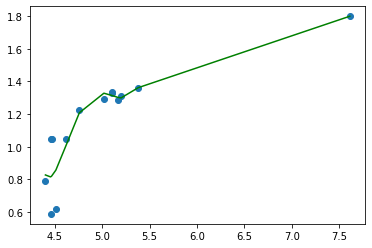

Root Mean Square Error:  0.1254259601917106


Use polynomial regression with degree = 7: 


Model coefficient:  [[ 0.00000000e+00  3.83904079e+06 -2.25376819e+06  7.31796361e+05
  -1.41881885e+05  1.64182157e+04 -1.04937373e+03  2.85594449e+01]]
Model intercept:  [-2791031.22093531]


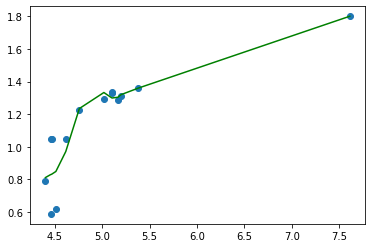

Root Mean Square Error:  0.12443808175613348


Use polynomial regression with degree = 8: 


Model coefficient:  [[ 0.00000000e+00  2.20508935e+05  2.19435868e+05 -2.31112595e+05
   9.16398331e+04 -1.96953913e+04  2.42743599e+03 -1.61889881e+02
   4.54246209e+00]]
Model intercept:  [-481603.12542156]


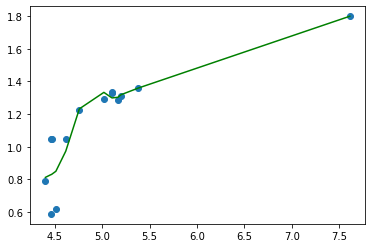

Root Mean Square Error:  0.1245549524310444


Use polynomial regression with degree = 9: 


Model coefficient:  [[ 0.00000000e+00  1.28702329e+04  2.80949167e+04  1.68564117e+04
  -2.75620091e+04  1.24796058e+04 -2.88113627e+03  3.71737943e+02
  -2.55980661e+01  7.35415395e-01]]
Model intercept:  [-107672.65966662]


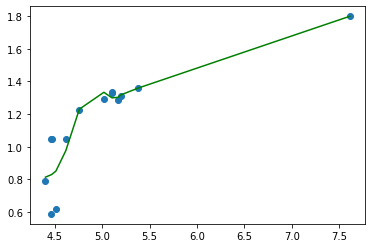

Root Mean Square Error:  0.12466455959193527


Use polynomial regression with degree = 10: 


Model coefficient:  [[ 0.00000000e+00  7.38278931e+02  2.29145175e+03  3.63403609e+03
   1.55562045e+03 -3.64361530e+03  1.80409158e+03 -4.37779688e+02
   5.83862795e+01 -4.11774579e+00  1.20460456e-01]]
Model intercept:  [-29628.45146375]


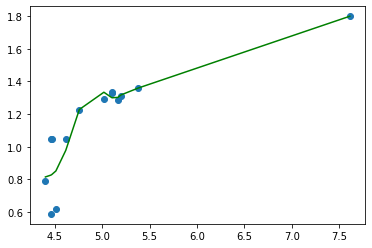

Root Mean Square Error:  0.12476597310361807


Min rmse: 0.12443808175613348 with model with degree: 7


In [69]:
from numpy.lib import polynomial
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def getData(post_type, street, ward, district):
    
    conn = psycopg2.connect(database="real_estate_data", user="postgres", password="361975Warcraft")
    # cur = conn.cursor()
    query = """
        SELECT area, price, street, ward, district
        FROM bds_realestatedata 
        WHERE
            post_type = '{}' AND
            area IS NOT NULL AND
            price IS NOT NULL AND
            street = '{}' AND
            ward = '{}' AND
            district = '{}';
    """.format(post_type, street, ward, district)
    
    # cur.execute(query)
    # data = cur.fetchall()
    data = pd.read_sql_query(query, con=conn)
    
#     print(data.head())
#     print("Data length: {}\n".format(len(data)))

    return prepareData(data)
#     return data

def prepareData(data):
    
    # Drop duplicates:    
    data.drop_duplicates(subset='area', keep='first', inplace=True)
    
    # Sort data by area column:
    data = data.sort_values(by=['area'])

    # use percentiles to remove outliers:
    area_upper_bound = data['area'].quantile(0.95)
    area_lower_bound = data['area'].quantile(0.05)
    price_upper_bound = data['price'].quantile(0.95)
    price_lower_bound = data['price'].quantile(0.05)

    data = data[
        (data['area'] < area_upper_bound) &
        (data['area'] > area_lower_bound) &
        (data['price'] < price_upper_bound) &
        (data['price'] > price_lower_bound)
    ]
    
#     print(data.head())
#     print("Data length: {}\n".format(len(data)))

#     Use log transformation to scale data:

    log_transform_area = (data['area']+1).transform(np.log)
    log_transform_price = (data['price']+1).transform(np.log)
    log_transform_data = pd.DataFrame({'area': log_transform_area, 'price': log_transform_price, 'street': data['street'], 'ward': data['ward'], 'district': data['district']})

    print("--------------------------------------------------------")
    print(log_transform_data.head())
    print("--------------------------------------------------------")
    print("Log Transformation Data length: ", len(log_transform_data))

    return log_transform_data
#     return data

def splitData(data):
    # Selection few attributes
    attributes = ['area',]
    predict_val = ['price']
    
    # Vector attributes of lands
    X = data[attributes]
    # Vector price of land
    Y = data[predict_val]
    
    # Convert into arr:
    X = np.array(X)
    Y = np.array(Y)
    
    # Split data to training test and testing test
    # training data : testing data = 80 : 20
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
    # return X_train, X_test, Y_train, Y_test
    
    return X, Y

# Linear Regression Model:
def linearRegressionModel(X, Y):
    model = linear_model.LinearRegression()

    # Training process
    model.fit(X, Y)
    
    # return model coefficient, intercept:
    return model

# Polynomial Regression:
def polynomialRegression(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    # calc linear regression again:
    poly_model = linearRegressionModel(X_poly, Y)
    return poly_model, X_poly

def degree_test(degree):
    print("\n\nUse polynomial regression with degree = {}: \n\n".format(degree))
    
    # Call polynomial regression
    poly_model, X_poly = polynomialRegression(degree)
    
    poly_model_coef = poly_model.coef_
    poly_model_intercept = poly_model.intercept_
    Y_poly_pred = poly_model.predict(X_poly)
    
    print("Model coefficient: ", poly_model_coef)
    print("Model intercept: ", poly_model_intercept)
    
    # print("Model: y = {} + {}x + {}x^2 + {}".format(model_coef[0], model_coef[1], model_coef[2], model_intercept))

    # Plot model:
    plt.scatter(X, Y)
    # plt.plot(X, poly_model_coef[0] + poly_model_coef[1]*X + poly_model_coef[2]*pow(X, 2) + poly_model_intercept, color='red')
    plt.plot(X, Y_poly_pred, color='green')
    plt.show()

    # Find root mean square error of model between Y_predict and Y
    rmse = np.sqrt(mean_squared_error(Y, Y_poly_pred))
    print("Root Mean Square Error: ", rmse)

    return poly_model, rmse

# Data:
post_type = 'Bán đất'
street = 'Đoàn Nguyễn Tuấn'
ward = 'Quy Đức'
district = 'Bình Chánh'

data = getData(post_type, street, ward, district)
X, Y = splitData(data)

model = linearRegressionModel(X, Y)
model_coef = model.coef_
model_intercept = model.intercept_
Y_pred = model.predict(X)

""" 
y = ax1 + b
[a] is coefficient
b is intercept
"""

print("Model coefficient: ", model_coef)
print("Model intercept ", model_intercept)

# Plot model:
plt.scatter(X, Y)
# plt.plot(X, model_coef*X + model_intercept, color='y')
plt.plot(X, Y_pred, color='yellow')
plt.show()

# Find root mean square error of model between Y_predict and Y
linear_rmse = np.sqrt(mean_squared_error(Y, Y_pred))
print("Root Mean Square Error: ", linear_rmse)

min_rmse = linear_rmse
selected_model = linear_model
degree = 1
for i in range(2, 11):
    poly_model, rmse = degree_test(i)
    if rmse < min_rmse:
        min_rmse = rmse
        selected_model = poly_model
        degree = i
print("\n\nMin rmse: {} with model with degree: {}".format(min_rmse, degree))